In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
matplotlib.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## PART A
<br>
Belgian traffic signs dataset from this source:
https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6 
https://github.com/georgesung/ssd_tensorflow_traffic_sign_detection

Tensoflow Traffic Sign Recognition with TensorFlow
https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6


In [6]:
! ls

ML_HW_6_BBeckwith.ipynb Testing                 Training


The load data function loops through the directory folder by folder and uses the name of the file as the way to evaluate the accuracy of the model. The images that are used in the model are saved in .ppm format, instead of jpeg which is how most computers render the image.  

In [129]:
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    print (directories)
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:

        label_dir = os.path.join(data_dir, d)

        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels



In [130]:
images, labels = load_data('Training')

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00056', '00057', '00058', '00059', '00060', '00061']


In [9]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))


Unique Labels: 62
Total Images: 4575


The display images and labels function reveals the images with the labels (as the actual). 

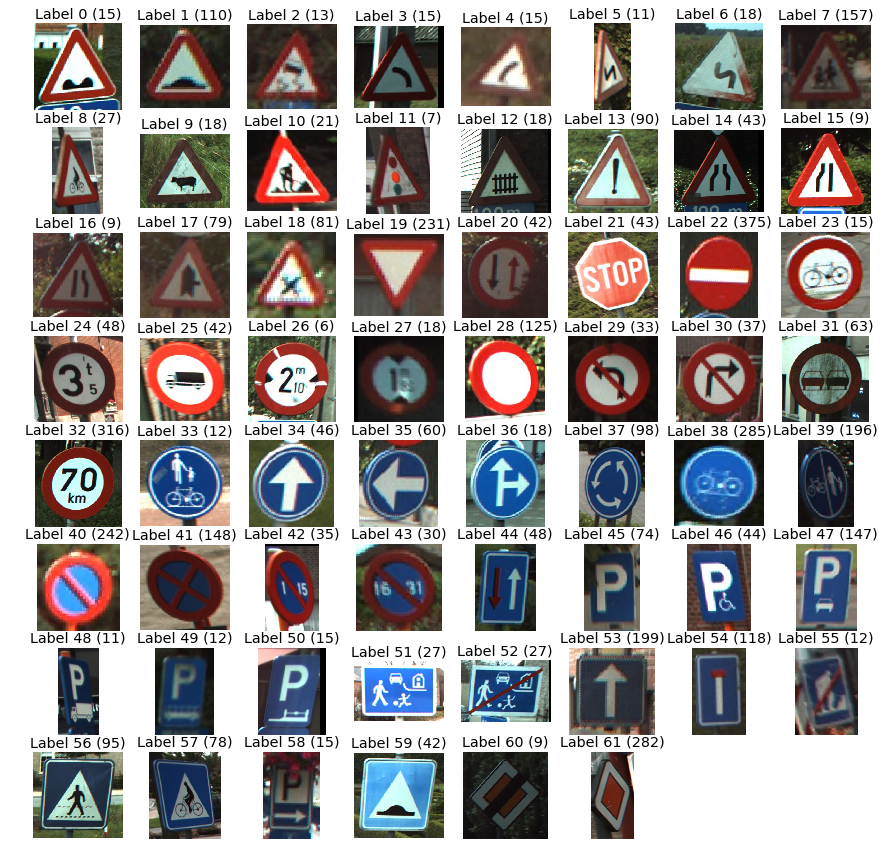

In [10]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

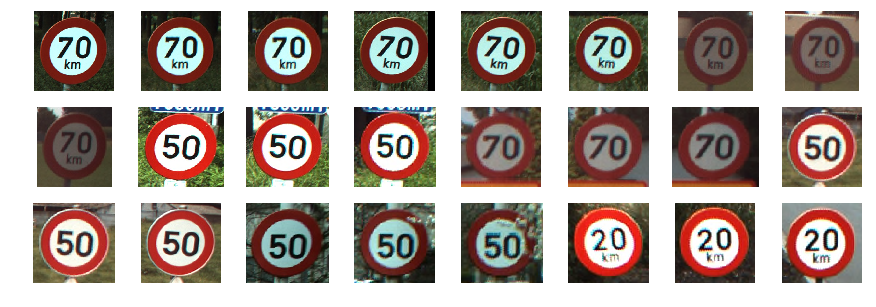

In [11]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)

In [12]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (141, 142, 3), min: 0, max: 255
shape: (120, 123, 3), min: 0, max: 255
shape: (105, 107, 3), min: 0, max: 255
shape: (94, 105, 3), min: 7, max: 255
shape: (128, 139, 3), min: 0, max: 255


This command reformats the images to a 32 by 32 shape. 

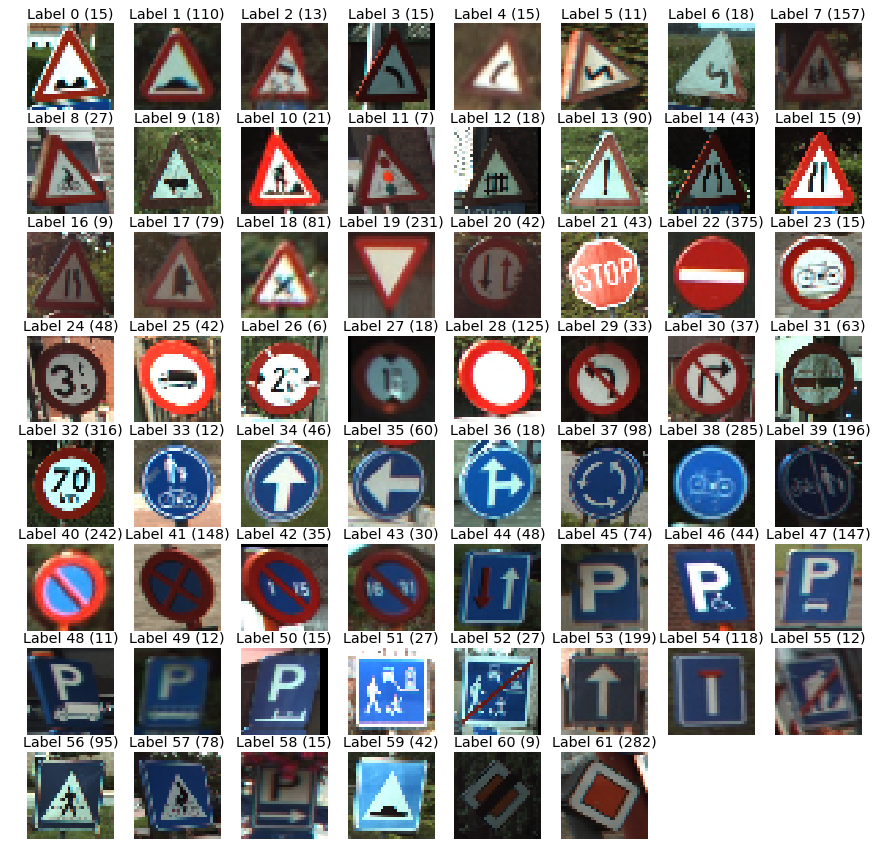

In [13]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
display_images_and_labels(images32, labels)

In [14]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.0073912377450982, max: 1.0
shape: (32, 32, 3), min: 0.003576899509804572, max: 1.0
shape: (32, 32, 3), min: 0.0015567555147058805, max: 1.0
shape: (32, 32, 3), min: 0.056774662990195915, max: 0.969267003676469
shape: (32, 32, 3), min: 0.026654411764708223, max: 0.9895220588235292


In [15]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


The tensorflow model uses a ReLu activation model. ReLU function is f(x)=max(0,x).f(x)=max(0,x). Usually this is applied element-wise to the output of some other function, such as a matrix-vector product. 

The learning rate is set to 0.001, the learning rate is best when it is near the highest stable learning rate and learning rate decay is used over the course of training. The reason behind this is that early on there is a clear learning signal so aggressive updates encourage exploration while later on the smaller learning rates allow for more delicate exploitation of local error surface.

source: https://datascience.stackexchange.com/questions/410/choosing-a-learning-rate 

In [17]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    # TODO: rename to tf.global_variables_initializer() on TF 0.12.
    init = tf.initialize_all_variables()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
images_flat:  Tensor("Flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


In [18]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

The session allows you save the model and export it if needed

In [19]:
for i in range(201):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

Loss:  4.25363
Loss:  2.92379
Loss:  2.444
Loss:  2.20375
Loss:  2.06545
Loss:  1.97217
Loss:  1.90236
Loss:  1.84712
Loss:  1.80165
Loss:  1.76332
Loss:  1.7304
Loss:  1.70172
Loss:  1.67645
Loss:  1.65394
Loss:  1.63374
Loss:  1.61549
Loss:  1.59891
Loss:  1.58379
Loss:  1.56992
Loss:  1.55714
Loss:  1.54534


In [20]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[38, 22, 32, 22, 28, 39, 61, 61, 0, 37]
[38 22 32 22 28 39 61 61  1 39]


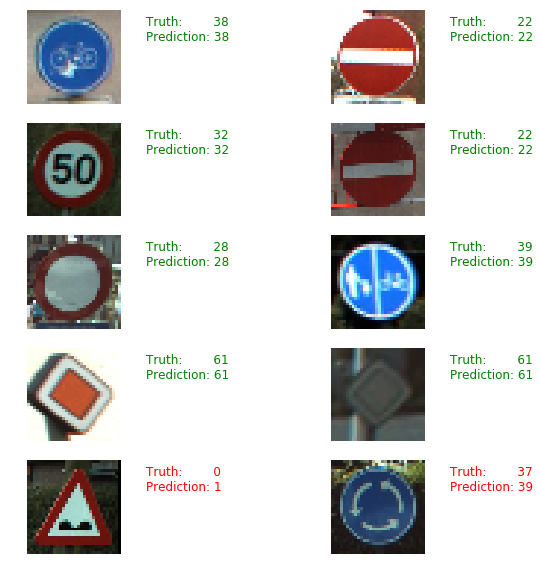

In [21]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

In [58]:
# Load the test dataset.
test_images, test_labels = load_data("Testing")

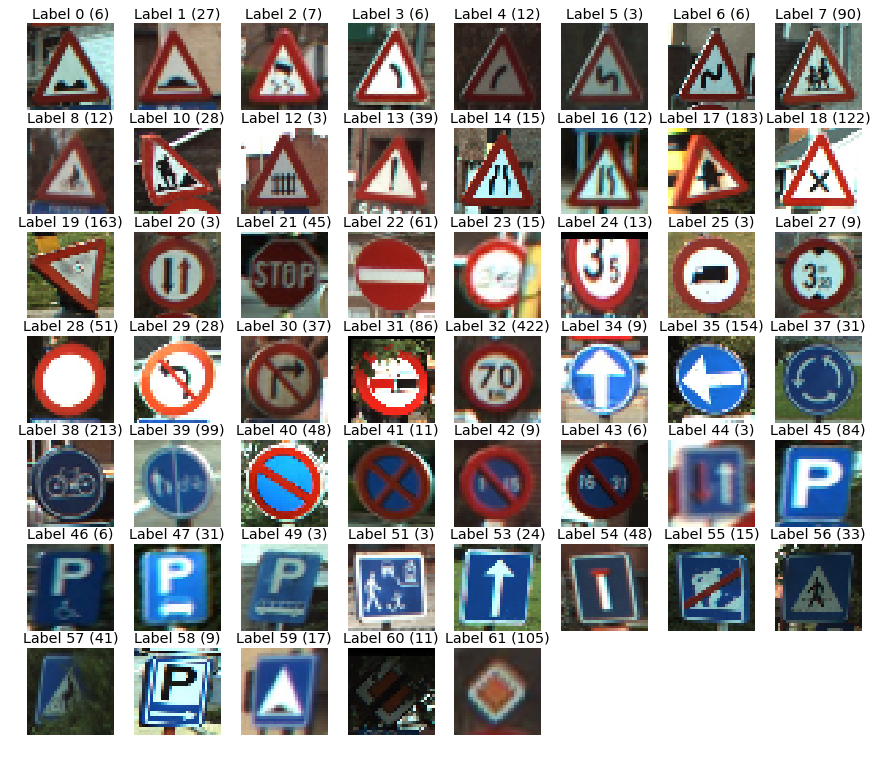

In [59]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32))
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [60]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.676


The accuracy on test data is .676% on unseen inputs. 

--------

Adding in the extra sample data from https://github.com/georgesung/ssd_tensorflow_traffic_sign_detection
These images were in png, so I had to crop them to the sign and convert them to PPM. After that was done, I had to appropriately name the files as that was the way the load_data function works. 

In [113]:
def load_data2(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    print (directories)
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        print(d)
        label_dir = os.path.join(data_dir, d)
        print(label_dir)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".PPM")]
        print (file_names)
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [114]:
images, labels = load_data2('OOS')

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007']
00000
OOS/00000
['OOS/00000/01799_00000.PPM']
00001
OOS/00001
['OOS/00001/01799_00001.PPM']
00002
OOS/00002
['OOS/00002/01799_00002.PPM']
00003
OOS/00003
['OOS/00003/01799_00003.PPM']
00004
OOS/00004
['OOS/00004/01799_00004.PPM']
00005
OOS/00005
['OOS/00005/01799_00005.PPM']
00006
OOS/00006
['OOS/00006/01799_00006.PPM']
00007
OOS/00007
['OOS/00007/01799_00007.PPM']


In [121]:
# Transform the images, just like we did with the training set.
OOS_images32 = [skimage.transform.resize(image, (32, 32))
                 for image in images]

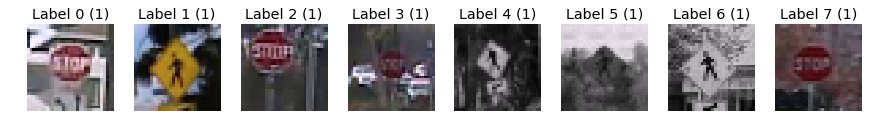

In [123]:
display_images_and_labels(OOS_images32, labels)

In [126]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: OOS_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(labels, predicted)])
accuracy = match_count / len(labels)
print("Accuracy: {:.3f}".format(accuracy))
print (predicted)

Accuracy: 0.000
[61 61 19 61 34 61 61 61]


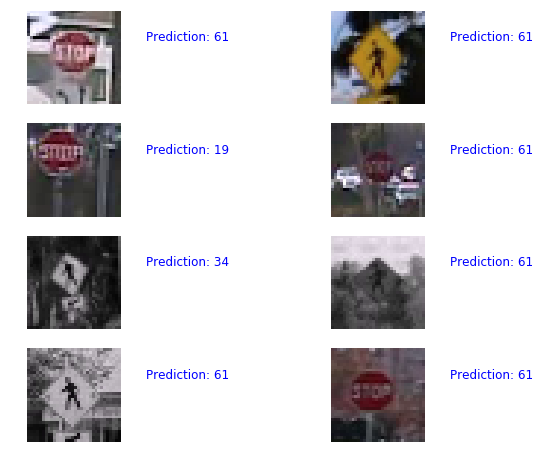

In [128]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(OOS_images32)):
    truth = labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'blue'
    plt.text(40, 10, "Prediction: {0}".format(prediction), 
             fontsize=12, color=color)
    plt.imshow(OOS_images32[i])

The model did not predict any of the new data correctly. This is likely because I did not give it the right predicting comparable label as I could not find where each sign had it's intended label. This made it hard to do a true out of sample. Although, I think the success of the out of sample is how I was able to get it into the right format to even be predicted upon. 

## PART B
<br>
Implement a Neural Networks classifier using Tensorflow on MNIST handwritten digits recognition data set.

https://www.analyticsvidhya.com/blog/2016/10/an-introduction-to-implementing-neural-networks-using-tensorflow/
https://www.tensorflow.org/get_started/mnist/beginners
http://adventuresinmachinelearning.com/python-tensorflow-tutorial/


In [41]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

FLAGS = None

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [42]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

The Gradient Descent Optimizer uses cross entropy which is an error function and logistic regression. Cross entropy can be used to define the loss function in machine learning and optimization. The true probability is the true label, and the given distribution is the predicted value of the current model

Gradient descent is a way to minimize an objective function parameterized by a model's parameters by updating the parameters in the opposite direction of the gradient of the objective function to the parameters. The learning rate determines the size of the steps we take to reach a (local) minimum.

In [43]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [44]:
sess = tf.InteractiveSession()

In [45]:
tf.global_variables_initializer().run()

In [46]:
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [47]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [48]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [49]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.098
